In [1]:
import numpy as np 
import pandas as pd 
import torch
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import zipfile
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from torchvision import transforms
import os
from data.translate import translate

In [3]:
df = pd.DataFrame(columns=['file', 'animal'])
label_map = {}
c = 0
for dirname, _, filenames in os.walk('./data/raw-img/'):
    files = filenames
    if files:
        files = pd.Series([os.path.join(dirname, f) for f in files], dtype=str)
        animal = pd.Series([c for _ in files], dtype=int)
        label_map[c] = translate[dirname.split('/')[-1]]
        tmp = pd.DataFrame({'file':files, 'animal':animal})
        df = df.append(tmp)
        c += 1
        
df.reset_index(inplace=True)
del df['index']

In [43]:
df.to_csv('train.csv', index=False)

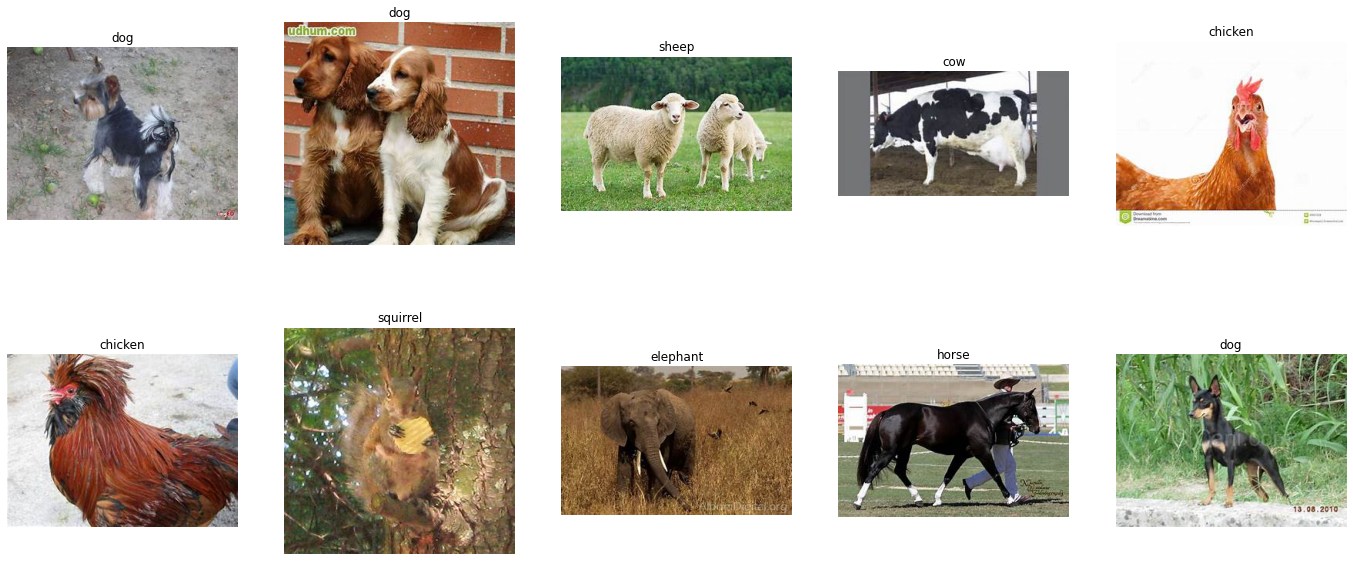

In [7]:
dfs = df.sample(10)
fs = dfs['file']
cs = dfs['animal']
fig = plt.figure(figsize=(24, 16))
for i, (f,c) in enumerate(zip(fs, cs)):
    ax = fig.add_subplot(3,5, 1 + i)
    ax.axis('off')
    ax.set_title(label_map[c])
    img = Image.open(f)
    ax.imshow(img)

In [44]:
label_map

{0: 'dog',
 1: 'horse',
 2: 'elephant',
 3: 'butterfly',
 4: 'chicken',
 5: 'cat',
 6: 'cow',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

In [10]:
NUM_CLASSES = 10
ID_COLNAME = 'file'
ANSWER_COLNAME = 'animal'
LABEL = label_map
IMG_SIZE = 64
N_EPOCHS = 10

In [11]:
train_augmentation = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

val_augmentation = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [12]:
class IMetDataset(Dataset):
    def __init__(self,
                 df,
                 n_classes = NUM_CLASSES,
                 id_colname = ID_COLNAME,
                 answer_colname = ANSWER_COLNAME,
                 label_dict = LABEL,
                 transforms = None
                ):
        self.df = df
        self.n_classes = n_classes
        self.id_colname = id_colname
        self.answer_colname = answer_colname
        self.label_dict = label_dict
        self.transforms = transforms
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        cur_idx_row = self.df.iloc[idx]
        img_file = cur_idx_row[self.id_colname]
        cls = cur_idx_row[self.answer_colname]
        img = Image.open(img_file).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.answer_colname is not None:              
            label = torch.zeros((self.n_classes,), dtype=torch.float32)
            label[cur_idx_row[self.answer_colname]] = 1.0

            return img, label
        
        else:
            return img, img_file

In [14]:
train_df, test_df = train_test_split(df, test_size = 0.15, shuffle = True)

In [15]:
def cuda(x):
    return x.cuda(non_blocking=True)

def f1_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 1, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [16]:
def train_one_epoch(model, train_loader, criterion, optimizer, steps_upd_logging = 250):
    model.train();
    
    total_loss = 0.0
    loader = iter(train_loader) 
    step = 0
    for features, targets in loader:
        step += 1
        features, targets = cuda(features), cuda(targets)
        optimizer.zero_grad()
        
        logits = model(features)
        
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (step + 1) % steps_upd_logging == 0:
            logstr = f'Train loss on step {step + 1} was {round(total_loss / (step + 1), 5)}'
            #train_tqdm.set_description(logstr)
            print(logstr)
        
    return total_loss / (step + 1)


def validate(model, valid_loader, criterion, need_tqdm = False):
    model.eval();
    
    test_loss = 0.0
    TH_TO_ACC = 0.5
    
    true_ans_list = []
    preds_cat = []
    step = 0
    with torch.no_grad():
        step += 1
        if need_tqdm:
            valid_iterator = tqdm_notebook(valid_loader)
        else:
            valid_iterator = iter(valid_loader)
        
        for features, targets in valid_iterator:
            features, targets = cuda(features), cuda(targets)

            logits = model(features)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            true_ans_list.append(targets)
            preds_cat.append(torch.sigmoid(logits))

        all_true_ans = torch.cat(true_ans_list)
        all_preds = torch.cat(preds_cat)
                
        f1_eval = f1_score(all_true_ans, all_preds).item()

    logstr = f'Mean val f1: {round(f1_eval, 5)}'
    print(logstr)
    return test_loss / (step + 1), f1_eval

In [17]:
model = models.densenet121(pretrained='imagenet')
model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [19]:
train_dataset = IMetDataset(train_df, transforms = train_augmentation)
test_dataset = IMetDataset(test_df, transforms = val_augmentation)

BS = 64

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

In [20]:
#% time 
TRAIN_LOGGING_EACH = 100

train_losses = []
valid_losses = []
valid_f1s = []
best_model_f1 = 0.0
best_model = None
best_model_ep = 0

for epoch in range(1, N_EPOCHS + 1):
    ep_logstr = f"Starting {epoch} epoch..."
    print(ep_logstr)
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, TRAIN_LOGGING_EACH)
    train_losses.append(tr_loss)
    tr_loss_logstr = f'Mean train loss: {round(tr_loss,5)}'
    print(tr_loss_logstr)
    
    valid_loss, valid_f1 = validate(model, test_loader, criterion)  
    valid_losses.append(valid_loss)    
    valid_f1s.append(valid_f1)       
    val_loss_logstr = f'Mean valid loss: {round(valid_loss,5)}'
    print(val_loss_logstr)
    sheduler.step(valid_loss)
    
    if valid_f1 >= best_model_f1:    
        best_model = model        
        best_model_f1 = valid_f1        
        best_model_ep = epoch

Starting 1 epoch...
Train loss on step 100 was 0.1759
Train loss on step 200 was 0.14339
Train loss on step 300 was 0.12865
Mean train loss: 0.12415
Mean val f1: 0.7507
Mean valid loss: 3.128
Starting 2 epoch...
Train loss on step 100 was 0.06647
Train loss on step 200 was 0.06807
Train loss on step 300 was 0.06952
Mean train loss: 0.06934
Mean val f1: 0.80299
Mean valid loss: 2.42045
Starting 3 epoch...
Train loss on step 100 was 0.04142
Train loss on step 200 was 0.04698
Train loss on step 300 was 0.04842
Mean train loss: 0.04843
Mean val f1: 0.81411
Mean valid loss: 2.78459
Starting 4 epoch...
Train loss on step 100 was 0.03454
Train loss on step 200 was 0.03536
Train loss on step 300 was 0.03649
Mean train loss: 0.0373
Mean val f1: 0.82404
Mean valid loss: 2.73373
Starting 5 epoch...
Train loss on step 100 was 0.02567
Train loss on step 200 was 0.02542
Train loss on step 300 was 0.02816
Mean train loss: 0.02883
Mean val f1: 0.83745
Mean valid loss: 2.70633
Starting 6 epoch...
Train

In [239]:
print(train_losses)

[]


In [275]:
len(train_df)//64

347

In [41]:
sample = test_df.sample(10)
model.eval();
for img, cls in zip(sample['file'], sample['animal']):
    y_hat = model(cuda(val_augmentation(Image.open(img))[None,:]))
    print(f'prediction: {label_map[torch.argmax(y_hat).item()]}, animal: {label_map[cls]}')

prediction: spider, animal: spider
prediction: spider, animal: spider
prediction: butterfly, animal: butterfly
prediction: butterfly, animal: butterfly
prediction: dog, animal: dog
prediction: chicken, animal: chicken
prediction: chicken, animal: chicken
prediction: spider, animal: spider
prediction: horse, animal: horse
prediction: dog, animal: dog


tensor(8, device='cuda:0')